# Base model

In [49]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math
import wandb
import json

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [50]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchinfo import summary

In [51]:
os.listdir()

['.DS_Store',
 'clicks.ipynb',
 'playground.ipynb',
 'pytorch.ipynb',
 'vis.ipynb',
 'decompress.ipynb',
 'unet.ipynb',
 'tensorflow.ipynb',
 'test_nb.ipynb',
 'test_nb_brats.ipynb']

In [52]:
data_path = '../data/all/'
# data_path = '../data/decompressed/'
# os.listdir(data_path)

In [53]:
# t1_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t1_*')))
# t2_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_t2_*')))
# seg_list = sorted(glob.glob(os.path.join(data_path, 'vs_*/*_seg_*')))

t1_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_t1_*')))
t2_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_t2_*')))
seg_list = sorted(glob.glob(os.path.join(data_path, 'VS-*-*/vs_*/*_seg_*')))

In [54]:
print(len(t1_list), len(t2_list), len(seg_list))

print(t1_list)
print(t2_list)
print(seg_list)

242 242 242
['../data/all/VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_11/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_12/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_13/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_14/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_15/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_16/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_17/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_18/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_19/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_2/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_20/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_21/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_22/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_23/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_24/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_25/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1

In [55]:
# shapes = {}
# for i, (t1_path, t2_path, seg_path) in enumerate(zip(t1_list, t2_list, seg_list)):
#     t1 = nib.load(t1_path).get_fdata()
#     t2 = nib.load(t2_path).get_fdata()
#     seg = nib.load(seg_path).get_fdata()
#     # print(t1.shape, t2.shape, seg.shape)
#     if i % 10 == 0:
#         print(f'Checked first {i} images')

#     if shapes.get(str(t1.shape)):
#         shapes[str(t1.shape)] = shapes[str(t1.shape)] + 1
#     else:
#         shapes[str(t1.shape)] = 1
# shapes

## Data generator

In [56]:
def get_glioma_indices(mask):
  first = torch.nonzero((mask == 1))[:,1][0].item()
  last = torch.nonzero((mask == 1))[:,1][-1].item()

  return first, last

In [57]:
# https://arxiv.org/abs/2011.01045
# https://github.com/lescientifik/open_brats2020/tree/main
def normalize(image):
    """ Basic min max scaler. """
    min_ = torch.min(image)
    max_ = torch.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    return image

In [58]:
def min_max_normalise(image: torch.Tensor) -> torch.Tensor:
    """ 
    Basic min-max scaler. \n
    https://arxiv.org/abs/2011.01045
    https://github.com/lescientifik/open_brats2020/tree/main
    """

    min_ = torch.min(image)
    max_ = torch.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    
    return image


class MRIDataset(Dataset):
    """ Torch Dataset which returns the stacked sequences and encoded mask. """
    
    def __init__(self, t1_list: tuple[str], t2_list: tuple[str], seg_list: tuple[str], img_dims: tuple[int], gen_clicks=False):
        self.t1_list = t1_list
        self.t2_list = t2_list
        self.seg_list = seg_list
        self.img_dims = img_dims
        self.gen_clicks = gen_clicks

    def __len__(self):
        return len(self.t1_list)
    
    def _get_glioma_indices(self, mask: torch.Tensor) -> tuple[int, int]:
        """ Returns the first and last slice indices of the tumour in given mask """
        
        first = torch.nonzero((mask == 1))[:,0][0].item()
        last = torch.nonzero((mask == 1))[:,0][-1].item()

        return first, last
    
    def _select_points(self, coords, n, d=4):
        valid_points = []
        valid_points.append(coords[0])
        
        i = 1
        while n != len(valid_points) and i < len(coords):
            new_point = coords[i]

            valid = True
            for p in valid_points:
                dist = np.linalg.norm(p - new_point)
                if dist < d:
                    valid = False
                    break
                
            if valid:
                valid_points.append(new_point)
            
            i += 1
        
        return valid_points

    def _generate_clicks(self, mask: torch.Tensor, fg=False, bg=False, clicks_num=2, click_size=2) -> tuple[torch.Tensor, torch.Tensor]:
        """ Generate click masks """

        first, last = self._get_glioma_indices(mask)
        mask = mask.numpy()

        bg_clicks = np.zeros_like(mask)
        fg_clicks = np.zeros_like(mask)
        for slice in range(first, last):
            erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))
            dilatation_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(17, 17))
            eroded_seg = cv2.erode(mask[slice,:,:], kernel=erosion_kernel)
            dilated_seg = cv2.dilate(mask[slice,:,:,], kernel=dilatation_kernel, iterations=4)

            diff = mask[slice,:,:] - eroded_seg
            diff2 = dilated_seg - mask[slice,:,:]

            border_idx = np.where(diff == 1)
            border_coords = list(zip(*border_idx))

            # Get fg coordinates
            inner_idx = np.where(mask[slice,:,:] == 1)
            inner_coords = list(zip(*inner_idx))
            inner_coords = list(set(inner_coords) - set(border_coords))
            np.random.shuffle(inner_coords)
            
            # Get bg coordinates
            outer_idx = np.where(diff2 == 1)
            outer_coords = list(zip(*outer_idx))
            outer_coords = list(set(outer_coords) - set(inner_coords))
            np.random.shuffle(outer_coords)

            # Add bg clicks
            if bg:
                selected_points = self._select_points(np.array(outer_coords), clicks_num)
                for c in selected_points:
                    bg_clicks[slice,c[0], c[1]] = 3

            # Add fg clicks
            if fg:
                selected_points = self._select_points(np.array(inner_coords), clicks_num)
                for c in selected_points:
                    fg_clicks[slice,c[0], c[1]] = 4

        return torch.stack((torch.as_tensor(bg_clicks), torch.as_tensor(fg_clicks)), axis=0)

    def _get_new_depth(self, mask: torch.Tensor):
        """ Calculates new (start, end indices) based on the position of the tumour """
        
        first, last = self._get_glioma_indices(mask)

        # new starting position will be 0, when the tumour starts low enough or 
        # couple slices bellow the first index so the tumour isnt in the first few
        # slices of the new volume
        start_index = max(first - (self.img_dims[0] // 2), 0)
        
        # new endposition is calculated so the final dimensions match with 
        # the requested ones in `self.img_dims`
        end_index = start_index + self.img_dims[0]
        
        return start_index, end_index
    
    def _normalise(self, volume: torch.Tensor) -> torch.Tensor:    
        """ Normalise given volume """
        # mean = torch.mean(volume, dim=(0, 1, 2), keepdim=True)
        # sd = torch.std(volume, dim=(0, 1, 2), keepdim=True)
        # return (volume - mean) / sd
        # return irm_min_max_preprocess(volume)
        
        return min_max_normalise(volume)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, None | torch.Tensor]:
        """
        Load the data and run the whole preprocessing pipeline. \n
        Returns the stacked sequences and encoded mask.
        """
        
        # Load the data
        t1 = torch.as_tensor(nib.load(self.t1_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
        t2 = torch.as_tensor(nib.load(self.t2_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
        seg = torch.as_tensor(nib.load(self.seg_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
        
        # Crop the image 
        if self.img_dims[1]*2 > t1.shape[1]:
            # t1 = TF.center_crop(t1, (self.img_dims[1]+60, self.img_dims[2]+60))
            # t2 = TF.center_crop(t2, (self.img_dims[1]+60, self.img_dims[2]+60))
            # seg = TF.center_crop(seg, (self.img_dims[1]+60, self.img_dims[2]+60))
            t1 = TF.center_crop(t1, (self.img_dims[1], self.img_dims[2]))
            t2 = TF.center_crop(t2, (self.img_dims[1], self.img_dims[2]))
            seg = TF.center_crop(seg, (self.img_dims[1], self.img_dims[2]))
        else:
            t1 = TF.center_crop(t1, (self.img_dims[1]*2, self.img_dims[2]*2))
            t2 = TF.center_crop(t2, (self.img_dims[1]*2, self.img_dims[2]*2))
            seg = TF.center_crop(seg, (self.img_dims[1]*2, self.img_dims[2]*2))

        # Crop the depth of the volumes when they have bigger depth than required
        if t1.shape[0] > self.img_dims[0]:
            start_index, end_index = self._get_new_depth(seg)
            t1 = t1[start_index:end_index,:,:]
            t2 = t2[start_index:end_index,:,:]
            seg = seg[start_index:end_index,:,:]
        
        # When the depth is smaller than required fill the difference with zeros     
        elif t1.shape[0] < self.img_dims[0]:
            pad = (0, 0, 0, 0, (self.img_dims[0]-t1.shape[0])//2, (self.img_dims[0]-t1.shape[0])//2)
            t1 = F.pad(t1, pad, "constant", 0)
            t2 = F.pad(t2, pad, "constant", 0)
            seg = F.pad(seg, pad, "constant", 0)
            # print(t1.shape[0], t2.shape[0], seg.shape[0])

        # Resizing to required width/height 
        t1 = TF.resize(t1, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)
        t2 = TF.resize(t2, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)
        seg = TF.resize(seg, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)

        # Normalisation
        t1 = self._normalise(t1)
        t2 = self._normalise(t2)
        stacked = torch.stack((t1, t2), axis=0)

        if self.gen_clicks:
            clicks = self._generate_clicks(seg, fg=True, bg=True, clicks_num=10, click_size=1)
            seg = seg.unsqueeze(0)
            return stacked, seg, clicks
        
        seg = seg.unsqueeze(0)
        return stacked, seg

### Testing data generator

In [59]:
data = MRIDataset([t1_list[124]], [t2_list[124]], [seg_list[124]], (64, 128, 128))
x, y = data[0]
x.shape, y.shape

(torch.Size([2, 64, 128, 128]), torch.Size([1, 64, 128, 128]))

#### Clicks

torch.Size([2, 64, 128, 128])


Text(0.5, 1.0, 'background clicks')

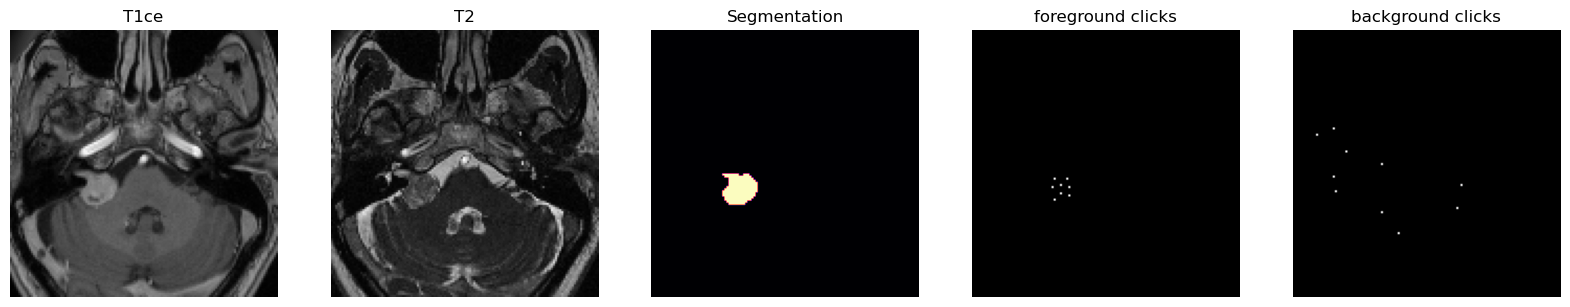

In [151]:
data = MRIDataset([t1_list[0]], [t2_list[0]], [seg_list[0]], (64, 128, 128), gen_clicks=True)
img, seg, clicks = data[0]

print(clicks.shape)

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
slice = 20
axs[0].imshow(img[0,slice,:,:].rot90(3), cmap='gray')
axs[0].axis('off')
axs[0].set_title('T1ce')

axs[1].imshow(img[1,slice,:,:].rot90(3), cmap='gray')
axs[1].axis('off')
axs[1].set_title('T2')

axs[2].imshow(seg[0,slice,:,:].rot90(3), cmap='magma')
axs[2].axis('off')
axs[2].set_title('Segmentation')

axs[3].imshow(clicks[1,slice,:,:].rot90(3), cmap='gray')
axs[3].axis('off')
axs[3].set_title('Foreground clicks')

axs[4].imshow(clicks[0,slice,:,:].rot90(3), cmap='gray')
axs[4].axis('off')
axs[4].set_title('Background clicks')

In [61]:
# a = np.array(list(zip(*torch.where(clicks[1,slice,:,:] == 4))))
# print(a)
# for p in a:
#     for pp in a:
#         print(np.linalg.norm(pp - p))
#     print()

tensor([0., 1., 3., 5.])

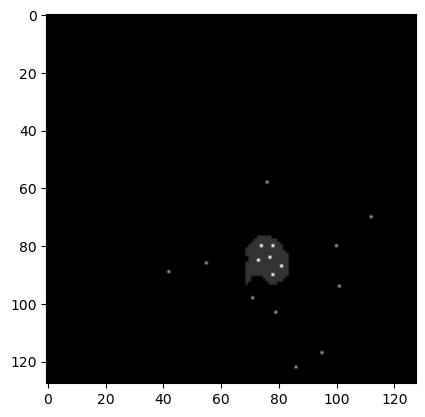

In [62]:
plt.imshow(seg[0,slice,:,:]+clicks[0,slice,:,:]+clicks[1,slice,:,:], cmap='grey')
torch.unique(seg[0,slice,:,:]+clicks[0,slice,:,:]+clicks[1,slice,:,:])

#### 40x80x80

In [63]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_list[0]], [t2_list[0]], [seg_list[0]], (40, 80, 80))

In [64]:
img, label = data[0]
print(img.shape, label.shape)
print(img.dtype, label.dtype)

torch.Size([2, 40, 80, 80]) torch.Size([1, 40, 80, 80])
torch.float32 torch.float32


Text(0.5, 1.0, 'Segmentation')

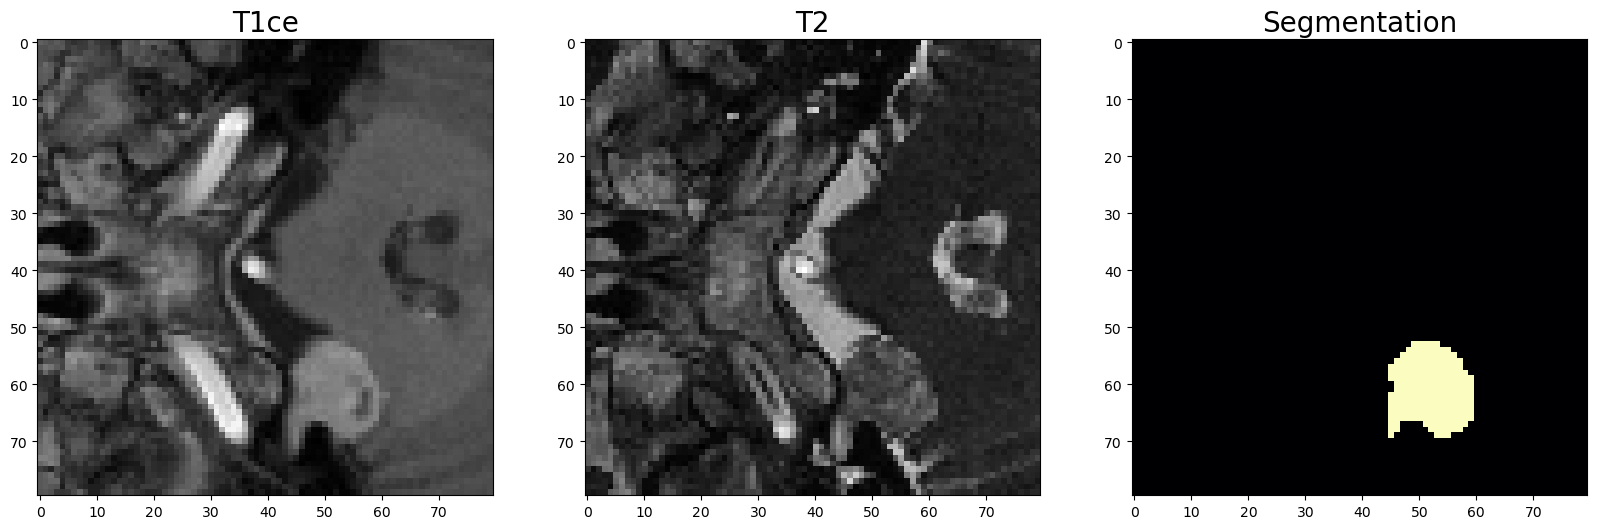

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
slice = 20
axs[0].imshow(x[0,slice,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,slice,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,slice,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

#### 40x128x128

torch.Size([2, 40, 128, 128]) torch.Size([1, 40, 128, 128])


Text(0.5, 1.0, 'Segmentation')

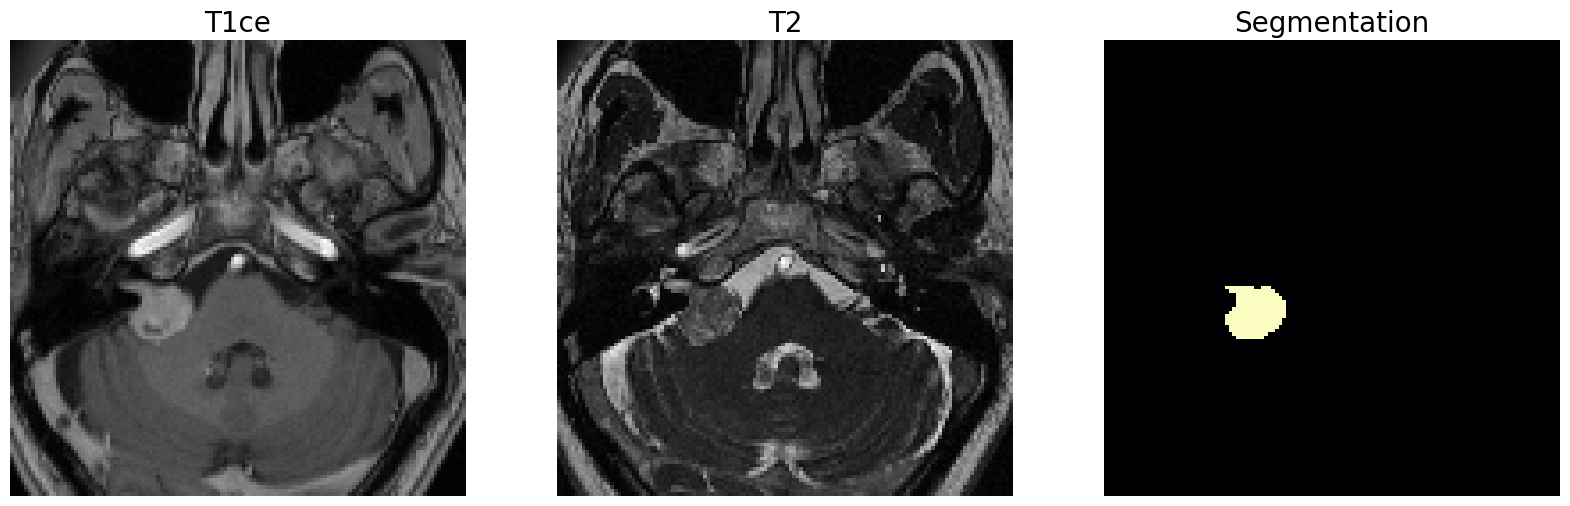

In [68]:
data = MRIDataset([t1_list[0]], [t2_list[0]], [seg_list[0]], (40, 128, 128))
# data = MRIDataset(
#     ['../data/all/VS-113-143/vs_gk_131/vs_gk_t1_refT2.nii.gz'], 
#     ['../data/all/VS-113-143/vs_gk_131/vs_gk_t2_refT2.nii.gz'], 
#     ['../data/all/VS-113-143/vs_gk_131/vs_gk_seg_refT2.nii.gz'], 
#     (64, 256, 256)
# )

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]

print(x.shape, y.shape)
slice = 20

axs[0].imshow(x[0,slice,:,:].rot90(3), cmap='gray')
axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,slice,:,:].rot90(3), cmap='gray')
axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,slice,:,:].rot90(3), cmap='magma')
axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

#### 64x256x256

torch.Size([2, 64, 256, 256]) torch.Size([1, 64, 256, 256])


Text(0.5, 1.0, 'Segmentation')

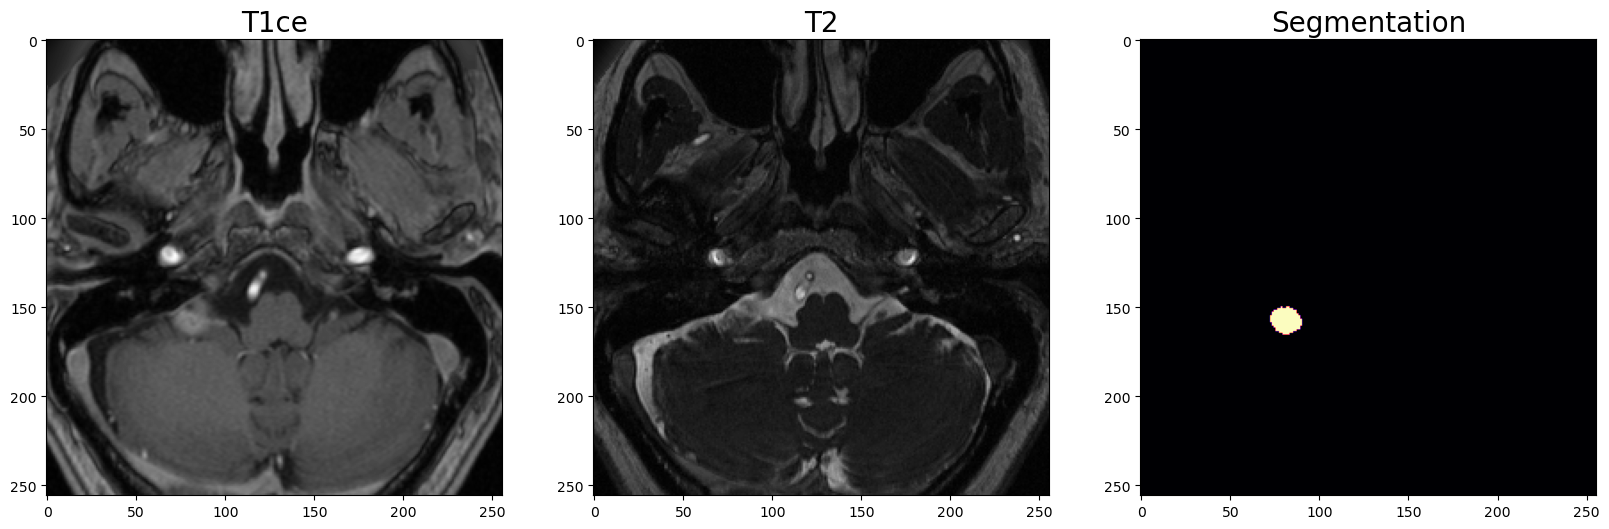

In [130]:
data = MRIDataset([t1_list[0]], [t2_list[0]], [seg_list[0]], (64, 256, 256))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]

print(x.shape, y.shape)
slice = 16

axs[0].imshow(x[0,slice,:,:].rot90(3), cmap='gray')
axs[0].set_title('T1ce', fontsize=20)
# axs[0].axis('off')
axs[1].imshow(x[1,slice,:,:].rot90(3), cmap='gray')
axs[1].set_title('T2', fontsize=20)
# axs[1].axis('off')
axs[2].imshow(y[0,slice,:,:].rot90(3), cmap='magma')
axs[2].set_title('Segmentation', fontsize=20)
# axs[2].axis('off')

#### 40x40x40

Text(0.5, 1.0, 'Segmentation')

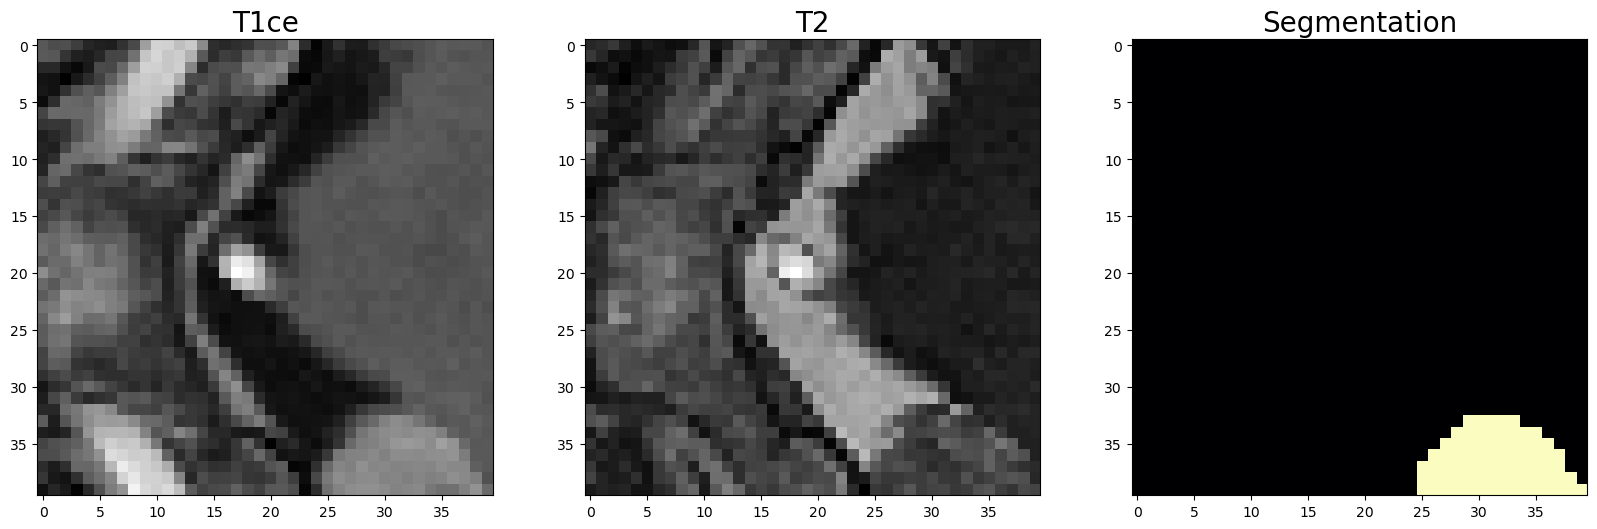

In [49]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_list[0]], [t2_list[0]], [seg_list[0]], (40, 40, 40))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
axs[0].imshow(x[0,20,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,20,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,20,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

### Class weights

In [ ]:
def get_class_count(seg):
  labels, counts = torch.unique(seg[0], return_counts=True)
  print(counts)
  print((counts[1]/counts[0]).item())


#### 40x128x128

In [ ]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 128, 128))

In [ ]:
classes = {0: 0, 1: 0}
for i in range(len(data)):
  x, y = data[i]
  labels, counts = torch.unique(y[0], return_counts=True)
  classes[0] += counts[0].item()
  classes[1] += counts[1].item()
  print(i, classes)

0 {0: 654653, 1: 707}
1 {0: 1309306, 1: 1414}


In [ ]:
# {0: 164753098, 1: 397622}
classes = {0: 164753098, 1: 397622}
classes[1] / classes[0]

0.0024134417187105035

In [ ]:
for i in range(len(data)):
  print('==========')
  print(f'scan: {i}')
  x, y = data[i]
  print('shapes: ', x[0].shape, x[1].shape, y[0].shape)
  get_class_count(y)

scan: 0
shapes:  torch.Size([40, 128, 128]) torch.Size([40, 128, 128]) torch.Size([40, 128, 128])
tensor([654653,    707])
0.0010799614246934652
scan: 1
shapes:  torch.Size([40, 128, 128]) torch.Size([40, 128, 128]) torch.Size([40, 128, 128])
tensor([654653,    707])
0.0010799614246934652


#### 40x80x80

In [ ]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 80, 80))

In [ ]:
classes = {0: 0, 1: 0}
for i in range(len(data)):
  x, y = data[i]
  labels, counts = torch.unique(y[0], return_counts=True)
  classes[0] += counts[0].item()
  classes[1] += counts[1].item()
  print(i, classes)

0 {0: 255293, 1: 707}
1 {0: 510586, 1: 1414}


In [ ]:
# {0: 64115061, 1: 396939}
classes = {0: 64115061, 1: 396939}
print(classes[1] / classes[0])
print(classes[0] / classes[1])

0.006191041446564326
161.52371271152495


In [ ]:
for i in range(len(data)):
  print('==========')
  print(f'scan: {i}')
  x, y = data[i]
  print('shapes: ', x[0].shape, x[1].shape, y[0].shape)
  classes[0] +
  get_class_count(y)

### Union over masks

In [ ]:
data = MRIDataset(t1_list, t2_list, seg_list, (40, 80, 80))

In [ ]:
masks_combined = torch.zeros((40, 80, 80))

In [ ]:
for i in range(len(data)):
  print(f'scan: {i}')
  _, y = data[i]
  masks_combined += y[0]

# i = 0
# for (_, mask) in data_gen:
#   mask = mask[0, :, :, :, 0]
#   masks_combined += mask
#   i += 1
#   if i%10==0: print(i)
# i

scan: 0
scan: 1


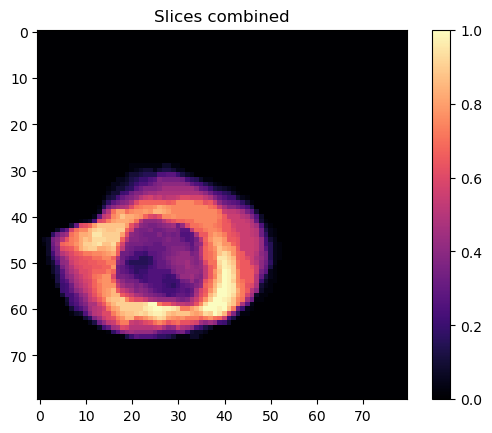

In [ ]:
summed = torch.sum(masks_combined, axis=0)
a = summed / summed.max()

plt.imshow(a, cmap='magma')
plt.title('Slices combined')
cb = plt.colorbar()
plt.show()

## Model

In [103]:
def build_conv_block(in_channels: tuple[int], out_channels: tuple[int]):
    """ 
    Creates a convolution block with: \n
    `3dConv -> 3dBatchNorm -> ReLu -> 3dConv -> 3dBatchNorm -> ReLu` 
    """
    
    return nn.Sequential(
        nn.Conv3d(in_channels[0], out_channels[0], kernel_size=3, padding=1, padding_mode='zeros'),
        nn.BatchNorm3d(out_channels[0]),
        nn.ReLU(),
        nn.Conv3d(in_channels[1], out_channels[1], kernel_size=3, padding=1, padding_mode='zeros'),
        nn.BatchNorm3d(out_channels[1]),
        nn.ReLU(),
    )


class DownBlock(nn.Module):
    """ 
    A downsample block built with one convolution block 
    and a `3dMaxPool` layer.
    """

    def __init__(self, in_channels: tuple[int], out_channels: tuple[int]):
        super().__init__()
        self.conv = build_conv_block(
            in_channels=[in_channels[0], in_channels[1]], 
            out_channels=[out_channels[0], out_channels[1]]
        )
        self.down = nn.MaxPool3d(kernel_size=2)

    def forward(self, x):
        out = self.conv(x)
        downscaled = self.down(out)

        return out, downscaled


class UpBlock(nn.Module):
    """
    An upsample block built with one `3dConvTranspose` followed
    by one convolution block.
    """
    def __init__(self, in_channels: tuple[int], out_channels: tuple[int]):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=2, stride=2)
        # self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = build_conv_block(in_channels=[in_channels[0], in_channels[1]], out_channels=[out_channels[1], out_channels[1]])

    def forward(self, x, skip):
        upscaled = self.up(x)
        # print(upscaled.shape, skip.shape)
        concat = torch.cat([skip, upscaled], dim=1)
        # print(concat.shape)
        out = self.conv(concat)
        # print(out.shape)

        # print()
        return out


class Unet(nn.Module):
    """
    Unet model with 3 downsampling blocks and 3 upsampling blocks, where
    one block consists of: \n
    `3dConv -> 3dBatchNorm -> ReLu -> 3dConv -> 3dBatchNorm -> ReLu`
    and a sampling operation (`3dMaxPool`/`3dConvTranspose`).
    """
    def __init__(self, in_channels, out_channels, blocks=3):
        super().__init__()
        self.downsampling_path = nn.ModuleList()
        self.upsampling_path = nn.ModuleList()

        if blocks == 3:
            channels = [in_channels, 32, 64, 128]
        elif blocks == 4:
            channels = [in_channels, 32, 64, 128, 256]

        # Downsampling path
        for i in range(0, len(channels)-1):
            self.downsampling_path.append(
                DownBlock(in_channels=[channels[i], channels[i+1]], out_channels=[channels[i+1], channels[i+1]])
            )
        
        # Bottle neck
        self.bottle_neck = build_conv_block(in_channels=[channels[-1], channels[-1]*2], out_channels=[channels[-1]*2, channels[-1]*2])
        
        # Upsampling path
        for i in range(len(channels)-1, 0, -1):
            self.upsampling_path.append(
                UpBlock(in_channels=[channels[i]*2, channels[i]], out_channels=[channels[i], channels[i]])
            )

        # Output
        self.output = nn.Sequential(
            nn.Conv3d(in_channels=channels[1], out_channels=out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = x

        # Downsampling path
        skips = []
        for block in self.downsampling_path:
            skip, out = block(out)
            skips.append(skip)
        
        # Bottle neck
        out = self.bottle_neck(out)

        # Upsampling path
        skips.reverse()
        for (block, skip) in zip(self.upsampling_path, skips):
            out = block(out, skip)

        # Output
        out = self.output(out)
        return out

In [104]:
summary(Unet(), input_size=(2, 2, 40, 128, 128))

TypeError: Unet.__init__() missing 2 required positional arguments: 'in_channels' and 'out_channels'

### Attention Unet

In [107]:
def build_conv_block(in_channels: tuple[int], out_channels: tuple[int]):
    """ 
    Creates a convolution block with: \n
    `3dConv -> 3dBatchNorm -> ReLu -> 3dConv -> 3dBatchNorm -> ReLu` 
    """
    
    return nn.Sequential(
        nn.Conv3d(in_channels[0], out_channels[0], kernel_size=3, padding=1, padding_mode='zeros'),
        nn.BatchNorm3d(out_channels[0]),
        nn.ReLU(),
        nn.Conv3d(in_channels[1], out_channels[1], kernel_size=3, padding=1, padding_mode='zeros'),
        nn.BatchNorm3d(out_channels[1]),
        nn.ReLU(),
    )


class DownBlock(nn.Module):
    """ 
    A downsample block built with one convolution block 
    and a `3dMaxPool` layer.
    """

    def __init__(self, in_channels: tuple[int], out_channels: tuple[int]):
        super().__init__()
        self.conv = build_conv_block(
            in_channels=[in_channels[0], in_channels[1]], 
            out_channels=[out_channels[0], out_channels[1]]
        )
        self.down = nn.MaxPool3d(kernel_size=2)

    def forward(self, x):
        out = self.conv(x)
        downscaled = self.down(out)

        return out, downscaled


class UpBlock(nn.Module):
    """
    An upsample block built with one `3dConvTranspose` followed
    by one convolution block.
    """
    def __init__(self, in_channels: tuple[int], out_channels: tuple[int]):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=2, stride=2)
        # self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = build_conv_block(in_channels=[in_channels[0], in_channels[1]], out_channels=[out_channels[1], out_channels[1]])

    def forward(self, x, skip):
        upscaled = self.up(x)
        # print(upscaled.shape, skip.shape)
        concat = torch.cat([skip, upscaled], dim=1)
        # print(concat.shape)
        out = self.conv(concat)
        # print(out.shape)

        # print()
        return out


class Unet(nn.Module):
    """
    Unet model with 3 downsampling blocks and 3 upsampling blocks, where
    one block consists of: \n
    `3dConv -> 3dBatchNorm -> ReLu -> 3dConv -> 3dBatchNorm -> ReLu`
    and a sampling operation (`3dMaxPool`/`3dConvTranspose`).
    """
    def __init__(self, in_channels, out_channels, blocks=3):
        super().__init__()
        self.downsampling_path = nn.ModuleList()
        self.upsampling_path = nn.ModuleList()

        if blocks == 3:
            channels = [in_channels, 32, 64, 128]
        elif blocks == 4:
            channels = [in_channels, 32, 64, 128, 256]

        # Downsampling path
        for i in range(0, len(channels)-1):
            self.downsampling_path.append(
                DownBlock(in_channels=[channels[i], channels[i+1]], out_channels=[channels[i+1], channels[i+1]])
            )
        
        # Bottle neck
        self.bottle_neck = build_conv_block(in_channels=[channels[-1], channels[-1]*2], out_channels=[channels[-1]*2, channels[-1]*2])
        
        # Upsampling path
        for i in range(len(channels)-1, 0, -1):
            self.upsampling_path.append(
                UpBlock(in_channels=[channels[i]*2, channels[i]], out_channels=[channels[i], channels[i]])
            )

        # Output
        self.output = nn.Sequential(
            nn.Conv3d(in_channels=channels[1], out_channels=out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # # Downsampling path
        # skip1, down1 = self.down1(x)
        # skip2, down2 = self.down2(down1)
        # skip3, down3 = self.down3(down2)
        # # skip4, down4 = self.down4(down3)

        # # Bottle neck
        # bottom = self.bottle_neck(down3)

        # # Expanding path
        # # up1 = self.up1(bottom, skip4)
        # up2 = self.up2(bottom, skip3)
        # up3 = self.up3(up2, skip2)
        # up4 = self.up4(up3, skip1)

        # # Output
        # out = self.output(up4)

        out = x

        # Downsampling path
        skips = []
        for block in self.downsampling_path:
            skip, out = block(out)
            skips.append(skip)
        
        # Bottle neck
        out = self.bottle_neck(out)

        # Upsampling path
        skips.reverse()
        for (block, skip) in zip(self.upsampling_path, skips):
            out = block(out, skip)

        # Output
        out = self.output(out)
        return out

## Training

In [ ]:
import IPython

In [ ]:
config = {
    "lr": 1e-3,
    "num_classes": 1,
    "img_channels": 2,
    "dataset": "Schwanoma",
    "epochs": 6,
    "batch_size": 2,
    "loss": "focaltversky", 
    "optimizer": "Adam",
    "augment": False,
    "scheduler": False,
}

In [ ]:
use_wandb = False
if use_wandb:
    wandb.login(key='a68b79c89593d1f8c50631508f2e618f3ba7ccf3')
    wandb.init(project="DP", entity="kuko", name=config["loss"], reinit=True, config=config)    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [85]:
def prepare_data():
    # t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = t1_list, t1_list, t2_list, t2_list, seg_list, seg_list
    # train_data = MRIDataset([t1_train[0],t1_train[0]], [t2_train[0],t2_train[0]], [seg_train[0], seg_train[0]], (40, 80, 80))
    # val_data = MRIDataset(t1_val, t2_val, seg_val, (40, 80, 80))

    t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = train_test_split(t1_list, t2_list, seg_list, test_size=0.2, train_size=0.8, random_state=420)
    t1_train.append(t1_val.pop(-1))
    t2_train.append(t2_val.pop(-1))
    seg_train.append(seg_val.pop(-1))

    train_data = MRIDataset(t1_train, t2_train, seg_train, (40, 80, 80))
    val_data = MRIDataset(t1_val, t2_val, seg_val, (40, 80, 80))

    print(len(train_data), len(val_data))
    print(len(t1_train), len(t2_train), len(seg_train))
    print(len(t1_val), len(t2_val), len(seg_val))

    train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)

    return train_dataloader, val_dataloader

In [86]:
train_dataloader, val_dataloader = prepare_data()

194 48
194 194 194
48 48 48


NameError: name 'config' is not defined

#### Loss functions

In [87]:
def dice_coefficient(y_pred, y_true, eps=1e-6):
  """ computes the dice coeff. for each class by summing over the depth, height, and width """

  intersection = torch.sum(y_pred * y_true, dim=[2, 3, 4])
  union = torch.sum(y_pred, dim=[2, 3, 4]) + torch.sum(y_true, dim=[2, 3, 4])
  dice = (2. * intersection + eps) / (union + eps)
  # print(dice.shape)

  return dice.mean()

In [88]:
class DiceLoss(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, y_pred, y_true):
    return 1 - dice_coefficient(y_pred, y_true)

In [89]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None):
        super(DiceBCELoss, self).__init__()
        self.weight = weight

    def forward(self, y_pred, y_true):  
        dice_loss = 1 - dice_coefficient(y_pred, y_true)
        bce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='mean', weight=self.weight)
        combined_loss = bce_loss + dice_loss
        
        return combined_loss

In [90]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        ce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        
        return loss

In [91]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         loss = torchvision.ops.sigmoid_focal_loss(inputs, targets, alpha=self.alpha, gamma=self.gamma, reduction='mean')
#         return loss

In [92]:
def tversky_index(y_pred, y_true, epsilon=1e-6, alpha=0.5, beta=0.5):
    TP = torch.sum(y_pred * y_true, dim=[2, 3, 4])    
    FP = torch.sum((1-y_true) * y_pred, dim=[2, 3, 4])
    FN = torch.sum(y_true * (1-y_pred), dim=[2, 3, 4])
    tversky = (TP + epsilon) / (TP + alpha*FP + beta*FN + epsilon)  
    
    return tversky.mean()

In [93]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_true, epsilon=1e-6):             
        tversky = tversky_index(y_pred, y_true, epsilon=epsilon, alpha=self.alpha, beta=self.beta)
        
        return 1 - tversky

In [94]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=.75):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, y_pred, y_true, epsilon=1e-6):      
        tversky = tversky_index(y_pred, y_true, epsilon=epsilon, alpha=self.alpha, beta=self.beta)
        focaltversky = (1 - tversky) ** self.gamma
        
        return focaltversky

In [95]:
# train_dataloader, val_dataloader = prepare_data()
# for i, (x, y) in enumerate(val_dataloader):
#     x, y = x.to(device), y.to(device)
#     y_pred = model(x)
#     print(y_pred)
#     print(F.binary_cross_entropy_with_logits(y_pred, y))
#     print(F.binary_cross_entropy(torch.sigmoid(y_pred), y))

#### Training

In [96]:
def preview(y_pred, y, dice, epoch=0):
  first, last = get_glioma_indices(y)
  length = (last-first+1)
  n_graphs = (length*2)//6
  rows = n_graphs
  cols = 6
  res = cols if cols > rows else rows

  fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
  axs = axs.flatten()
  j = 0
  for i in range(first, last):
    if j >= len(axs): break
    axs[j].imshow(y[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j].axis('off')
    axs[j].set_title(f'mask slice {i}', fontsize=9)
    axs[j+1].imshow(y_pred[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j+1].axis('off')
    axs[j+1].set_title(f'pred slice {i}', fontsize=9)
    j += 2
  fig.suptitle(f'Dice: {dice.item()}', fontsize=10)
  plt.subplots_adjust(top=0.9)
  # plt.show()
  fig.savefig(f'../training_outputs/{epoch}_preview.png')
  plt.close(fig)

In [97]:
# train_dataloader, val_dataloader = prepare_data()
# for i, (x, y) in enumerate(val_dataloader):
#     print(x.shape, y.shape)
#     x, y = x.to(device), y.to(device)
#     print(y.dtype)
#     print(get_glioma_indices(y[0]))
#     preview(y[0], y[0], 0, 0)
#     #print(get_glioma_indices(y))

In [98]:
def val(dataloader, model, loss_fn, epoch):
    model.eval()
    avg_loss, avg_dice = 0, 0
    # out = display(IPython.display.Pretty('starting...'), display_id=True)
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            # avg_loss += loss_fn(y_pred, y).item()
            # avg_dice += dice_coefficient(y_pred, y).item()

            # Compute loss
            loss = loss_fn(y_pred, y)
            avg_loss += loss.item()

            # Compute the dice coefficient
            dice = dice_coefficient(y_pred, y).item()
            avg_dice += dice

            # out.update(IPython.display.Pretty(f'validation step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, dice: {dice}'))
            print(f'validation step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, dice: {dice}', end='\r')

            if i==0:
              preview(y_pred[0], y[0], dice_coefficient(y_pred, y), epoch)

    avg_loss /= len(dataloader)
    avg_dice /= len(dataloader)
    print()

    return (avg_loss, avg_dice)

In [99]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
  model.train()
  avg_loss, avg_dice = 0, 0

  # out = display(IPython.display.Pretty(f'Epoch: {epoch}'), display_id=True)
  # out = display(IPython.display.Pretty('starting...'), display_id=True)
  for i, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # print(x.shape, y.shape)
    # print(x.dtype, y.dtype)

    optimizer.zero_grad()

    # Get prediction
    y_pred = model(x)

    # Compute loss
    loss = loss_fn(y_pred, y)
    # print(loss)
    avg_loss += loss.item()

    # Compute the dice coefficient
    dice = dice_coefficient(y_pred, y).item()
    avg_dice += dice

    # Update parameters
    loss.backward()
    optimizer.step()

    # out.update(IPython.display.Pretty(f'training step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, dice: {dice}'))
    print(f'training step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, dice: {dice}', end='\r')

  avg_loss /= len(dataloader)
  avg_dice /= len(dataloader)
  print()

  return (avg_loss, avg_dice)

In [100]:
if not os.path.isdir('../training_outputs'):
    os.mkdir('../training_outputs')

In [ ]:
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

classes = {0: 64115061, 1: 396939}
total_pixels = classes[0] + classes[1]
weight = torch.tensor(total_pixels/classes[0]).to(device)
# weight = torch.tensor(classes[0]/classes[1]).to(device)
# loss_fn = nn.BCELoss(weight=weight)
# loss_fn = DiceLoss()
# loss_fn = DiceBCELoss(weight=weight)
# loss_fn = FocalLoss(alpha=weight, gamma=2)
# loss_fn = TverskyLoss(alpha=.3, beta=.7)
loss_fn = FocalTverskyLoss(alpha=.3, beta=.7)

epochs = config['epochs']
train_history = {'loss': [], 'dice': []}
val_history = {'loss': [], 'dice': []}

train_dataloader, val_dataloader = prepare_data()

for epoch in range(epochs):
  print('-------------------------------')
  print(f'epoch: {epoch}')

  train_loss, train_dice = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
  val_loss, val_dice = val(val_dataloader, model, loss_fn, epoch)

  train_history['loss'].append(train_loss)
  train_history['dice'].append(train_dice)

  val_history['loss'].append(val_loss)
  val_history['dice'].append(val_dice)

  print(f'loss: {train_loss:>5f} dice: {train_dice:>5f}')
  print(f'val loss: {val_loss:>5f} val dice: {val_dice:>5f}')

  with open('../training_outputs/train_history.json', 'w') as f:
    json.dump(train_history, f)
  with open('../training_outputs/val_history.json', 'w') as f:
    json.dump(val_history, f)

  torch.save({
      'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()
  }, '../training_outputs/checkpoint.pt')

  if use_wandb:
    wandb.log({
        'epoch': epoch, 'loss': train_loss, 'dice': train_dice, 
        'val_loss':val_loss, 'val_dice': val_dice, 'lr': optimizer.param_groups[0]["lr"]
    })
    wandb.log({'preview': wandb.Image(f'../training_outputs/{epoch}_preview.png')})

    # artifact = wandb.Artifact('checkpoint', type='model', metadata={'val_dice': val_dice})
    # artifact.add_file('../training_outputs/checkpoint.pt')
    # wandb.run.log_artifact(artifact)

184 46
184 184 184
46 46 46
-------------------------------
epoch: 0
training step: 92/92, loss: 0.967104, dice: 0.0266876667737960868
validation step: 23/23, loss: 0.939110, dice: 0.051008842885494232
loss: 0.954763 dice: 0.038186
val loss: 0.947238 val dice: 0.044925
-------------------------------
epoch: 1
training step: 92/92, loss: 0.918187, dice: 0.070204555988311775
validation step: 23/23, loss: 0.829447, dice: 0.159135386347770724
loss: 0.908508 dice: 0.086039
val loss: 0.842396 val dice: 0.162616
-------------------------------
epoch: 2
training step: 92/92, loss: 0.974733, dice: 0.020500114187598234
validation step: 23/23, loss: 0.593973, dice: 0.471547603607177734
loss: 0.874676 dice: 0.127609
val loss: 0.701387 val dice: 0.337402
-------------------------------
epoch: 3
training step: 92/92, loss: 0.904837, dice: 0.081462576985359198
validation step: 23/23, loss: 0.642375, dice: 0.409187078475952155
loss: 0.776711 dice: 0.247217
val loss: 0.687168 val dice: 0.338821
-------

In [ ]:
if use_wandb:
    wandb.finish()

In [ ]:
import plotly.express as px

In [ ]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [ ]:
fig = px.line({'dice': train_history['dice'], 'val_dice': val_history['dice']})
fig.show()

## Evaluation

In [15]:
data = MRIDataset(
    ['../data/all/VS-113-143/vs_gk_131/vs_gk_t1_refT2.nii.gz'], 
    ['../data/all/VS-113-143/vs_gk_131/vs_gk_t2_refT2.nii.gz'], 
    ['../data/all/VS-113-143/vs_gk_131/vs_gk_seg_refT2.nii.gz'], 
    (64, 128, 128)
)

torch.Size([2, 40, 128, 128]) torch.Size([1, 40, 128, 128])
21


Text(0.5, 1.0, 'Segmentation')

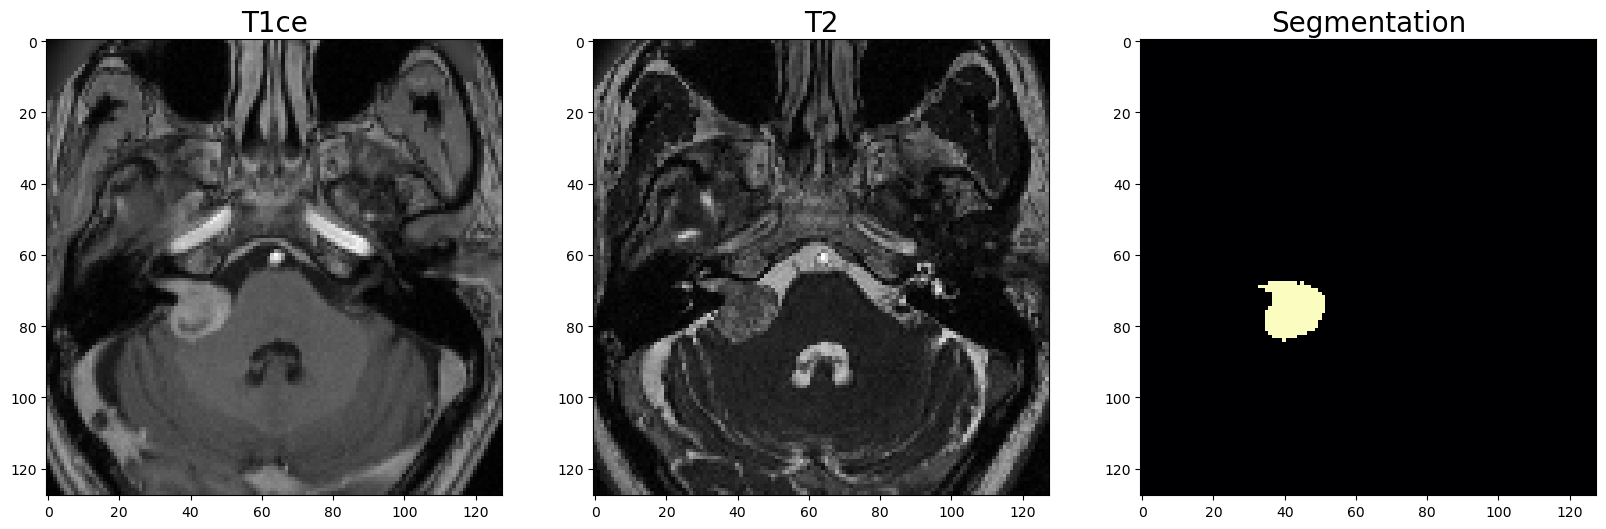

In [143]:
x, y = data[0]

fig, axs = plt.subplots(1, 3, figsize=(20, 20))

print(x.shape, y.shape)
first, last = get_glioma_indices(y)
slice = first + 5
print(slice)

axs[0].imshow(x[0,slice,:,:].rot90(3), cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,slice,:,:].rot90(3), cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,slice,:,:].rot90(3), cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

In [121]:
model = Unet(
    in_channels=2, 
    out_channels=1, 
    blocks=3
).to('cpu')

checkpoint = torch.load('../models/best.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state'])
# optimizer.load_state_dict(checkpoint['optimizer_state'])

<All keys matched successfully>

In [122]:
y_pred = model(x.unsqueeze(0))

In [123]:
dice = dice_coefficient(y_pred, y.unsqueeze(0)).item()
print(dice)

0.8994885683059692


In [131]:
t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = train_test_split(t1_list, t2_list, seg_list, test_size=0.2, train_size=0.8, random_state=420)
t1_train.append(t1_val.pop(-1))
t2_train.append(t2_val.pop(-1))
seg_train.append(seg_val.pop(-1))

train_data = MRIDataset(t1_train, t2_train, seg_train, (40, 80, 80))
val_data = MRIDataset(t1_val, t2_val, seg_val, (40, 128, 128))

print(len(train_data), len(val_data))
print(len(t1_train), len(t2_train), len(seg_train))
print(len(t1_val), len(t2_val), len(seg_val))

val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

194 48
194 194 194
48 48 48


In [147]:
for i, (x, y) in enumerate(val_dataloader):
    fig, axs = plt.subplots(1, 4, figsize=(20, 20))
    
    y_pred = model(x)
    dice = dice_coefficient(y_pred, y).item()

    first, last = get_glioma_indices(y)
    slice = 15
    axs[0].imshow(x[0,0,slice,:,:].rot90(3), cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('T1ce', fontsize=20)
    axs[1].imshow(x[0,1,slice,:,:].rot90(3), cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('T2', fontsize=20)
    axs[2].imshow(y[0,0,slice,:,:].rot90(3), cmap='magma')
    axs[2].axis('off')
    axs[2].set_title('Segmentation', fontsize=20)
    axs[3].imshow(y_pred[0,0,slice,:,:].rot90(3).detach(), cmap='magma')
    axs[3].axis('off')
    axs[3].set_title('Prediction', fontsize=20)
    
    fig.suptitle(f'Dice: {dice:1f}', fontsize=20)
    fig.savefig(f'../training_outputs/{i}_preview.png')
    plt.close(fig)
    if i == 10: break

## Playground

In [ ]:
train_data, _ = prepare_data()

In [ ]:
x, y = next(iter(train_data))

In [ ]:
(y == 1).nonzero()[0]

In [ ]:
def get_glioma_indices(volume):
  first = torch.nonzero((volume == 1))[:,0][0].item()
  last = torch.nonzero((volume == 1))[:,0][-1].item()
  return first, last

In [ ]:
for i in range(y.shape[0]):
  first = torch.nonzero((y[i] == 1))[:,1][0].item()
  last = torch.nonzero((y[i] == 1))[:,1][-1].item()
  print(f'first: {first}, last: {last}, diff: {last-first}')

In [ ]:
import math

In [ ]:
def crop_depth(volume, requested_depth):
  # requested_depth = 40
  # volume = y[1,0]
  first, last = get_glioma_indices(volume)
  # print(first, last)

  range_length = last - first + 1

  # Compute the desired padding size on both sides
  padding_size = requested_depth - range_length
  # print(padding_size, requested_depth, range_length)

  padding_size_left = math.floor(padding_size / 2)
  # print(padding_size_left)

  padding_size_right = math.ceil(padding_size / 2)
  # print(padding_size_right)

  # Compute the new start and end indices of the cropped depth dimension
  mid_index = (first + last) // 2
  start_index = max(mid_index - math.floor(requested_depth / 2), 0)
  end_index = min(start_index + requested_depth, volume.shape[0])

  # Crop the volume along the depth dimension
  cropped_volume = volume[start_index:end_index,:,:]

  return cropped_volume

In [ ]:
cropped_volume = crop_depth(y[1,0], 40)
cropped_volume.shape

In [ ]:
get_glioma_indices(cropped_volume)

In [ ]:
def test_cropping(data):
  for x, y in data:
    for i in range(x.shape[0]):
      first, last = get_glioma_indices(y[i,0])
      print(first, last, last - first)

      cropped = crop_depth(y[i,0], 40)
      print(cropped.shape)

      first, last = get_glioma_indices(cropped)
      print(first, last, last - first)
      print('======')

In [ ]:
train_data, val_data = prepare_data()

In [ ]:
test_cropping(val_data)

In [ ]:
plt.imshow(cropped_volume[23,:,:], cmap='magma')

In [ ]:
plt.imshow(y[0,0,28], cmap='magma')